# SpatialDataIntegration_SpatialProteomicsData

This tutorial demonstrates how to spatial data integration on spatial proteomics data using Pysodb and STAGATE+Harmony.

The reference paper can be found at https://www.nature.com/articles/s41467-022-29439-6 (STAGATE), https://www.nature.com/articles/s41592-019-0619-0 (Harmony) and https://www.cell.com/fulltext/S0092-8674(18)31100-0 (spatial proteomics data).

## Import packages and set configurations

In [1]:
# Use the Python warnings module to filter and ignore any warnings that may occur in the program after this point.
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import several Python packages commonly used in data analysis and visualization:
# pandas (imported as pd) is a package for data manipulation and analysis
import pandas as pd
# scanpy (imported as sc) is a package for single-cell RNA sequencing analysis
import scanpy as sc
# matplotlib.pyplot (imported as plt) is a package for data visualization
import matplotlib.pyplot as plt

In [3]:
# Import a STAGATE_pyG module
import STAGATE_pyG as STAGATE

If users encounter the error "No module named 'STAGATE_pyG'" when trying to import STAGATE_pyG package, first ensure that the "STAGATE_pyG" folder is located in the current script's directory.

In [4]:
# Imports a palettable package
import palettable
# Create two variables with lists of colors for categorical visualizations and biotechnology-related visualizations, respectively.
cmp_old = palettable.cartocolors.qualitative.Bold_10.mpl_colors
cmp_old_biotech = palettable.cartocolors.qualitative.Safe_4.mpl_colors

## Streamline development of loading spatial data with Pysodb

In [5]:
# Import pysodb package
# Pysodb is a Python package that provides a set of tools for working with SODB databases. 
# SODB is a format used to store data in memory-mapped files for efficient access and querying. 
# This package allows users to interact with SODB files using Python.
import pysodb

In [6]:
# Initialization
sodb = pysodb.SODB()

In [7]:
# Define names of dataset_name and experiment_name
dataset_name = 'keren2018a'
experiment_name = 'p4'
# Load a specific experiment
# It takes two arguments: the name of the dataset and the name of the experiment to load.
# Two arguments are available at https://gene.ai.tencent.com/SpatialOmics/.
adata = sodb.load_experiment(dataset_name,experiment_name)

load experiment[p4] in dataset[keren2018a]


In [8]:
# Create a dictionary named adata_list
adata_list = {}

In [9]:
# Modify the names and save in the dictionary with the key 'p4'. 
adata.obs_names = [x+'_p4' for x in adata.obs_names]
adata_list['p4'] = adata.copy()

In [10]:
# Define names of another dataset_name and experiment_name
dataset_name = 'keren2018a'
experiment_name = 'p9'
# Load another specific experiment
# It takes two arguments: the name of the dataset and the name of the experiment to load.
# Two arguments are available at https://gene.ai.tencent.com/SpatialOmics/.
adata = sodb.load_experiment(dataset_name,experiment_name)

load experiment[p9] in dataset[keren2018a]


In [11]:
# Update names and save in the dictionary under the key 'p9'
adata.obs_names = [x+'_p9' for x in adata.obs_names]
adata_list['p9'] = adata.copy()

## Running STAGATE for training

------Calculating spatial graph...
The graph contains 84154 edges, 6643 cells.
12.6681 neighbors per cell on average.


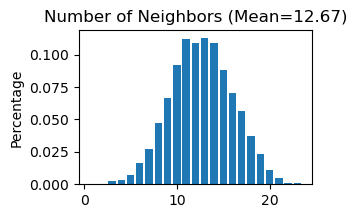

In [12]:
# Use "STAGATE_pyG.Cal_Spatial_Net" to calculate a spatial graph with a radius cutoff of 50 for adata_list['p4']
STAGATE.Cal_Spatial_Net(adata_list['p4'], rad_cutoff=50)
# Use "STAGATE_pyG.Stats_Spatial_Net" to summarize cells and edges information for adata_list['p4']
STAGATE.Stats_Spatial_Net(adata_list['p4'])

------Calculating spatial graph...
The graph contains 76056 edges, 6139 cells.
12.3890 neighbors per cell on average.


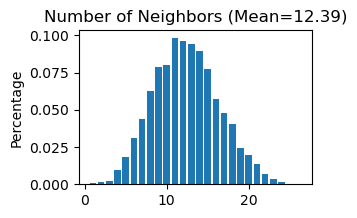

In [13]:
# Use "STAGATE_pyG.Cal_Spatial_Net" to calculate a spatial graph with a radius cutoff of 50 for adata_list['p9']
STAGATE.Cal_Spatial_Net(adata_list['p9'], rad_cutoff=50)
# Use "STAGATE_pyG.Stats_Spatial_Net" to summarize cells and edges information for adata_list['p9']
STAGATE.Stats_Spatial_Net(adata_list['p9'])

In [14]:
# Train the STAGATE model on each individual sample in the adata_list
for section_id in ['p4', 'p9']:
    adata_list[section_id] = STAGATE.train_STAGATE(adata_list[section_id],n_epochs=500)

Size of Input:  (6643, 36)


100%|██████████| 500/500 [00:03<00:00, 125.55it/s]


Size of Input:  (6139, 36)


100%|██████████| 500/500 [00:03<00:00, 162.64it/s]


In [15]:
# Concatenate 'p4' and 'p9' into a new AnnData object named 'adata'
adata = sc.concat([adata_list['p4'], adata_list['p9']], keys=None)

In [16]:
# Calculates neighbors in the 'STAGATE' representation, applies UMAP, and performs leiden clustering 
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
sc.tl.leiden(adata,resolution=0.08)

In [17]:
# Save UMAP and Leiden clustering results before integration
adata.obsm['UMAP_before'] = adata.obsm['X_umap']
adata.obs['leiden_before'] = adata.obs['leiden']

In [18]:
# Delete the STAGATE embedding from each individual sample
del adata.obsm['STAGATE']

In [19]:
# Concatenate two 'Spatial_Net'
adata.uns['Spatial_Net'] = pd.concat([adata_list['p4'].uns['Spatial_Net'], adata_list['p9'].uns['Spatial_Net']])

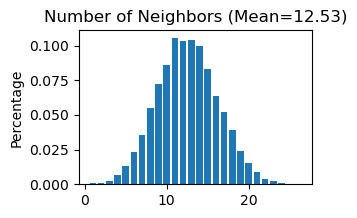

In [20]:
# Use "STAGATE_pyG.Stats_Spatial_Net" to summarize cells and edges information for whole adata
STAGATE.Stats_Spatial_Net(adata)

In [21]:
# Train the STAGATE model on the whole samples
adata = STAGATE.train_STAGATE(adata, n_epochs=500)

Size of Input:  (12782, 36)


 11%|█         | 54/500 [00:00<00:05, 86.13it/s]

100%|██████████| 500/500 [00:05<00:00, 85.97it/s]


In [22]:
# Create a new column 'Sample' by splitting each name and selecting the last element
adata.obs['Sample'] = [x.split('_')[-1] for x in adata.obs_names]

<Axes: title={'center': 'Unintegrated'}, xlabel='UMAP_before1', ylabel='UMAP_before2'>

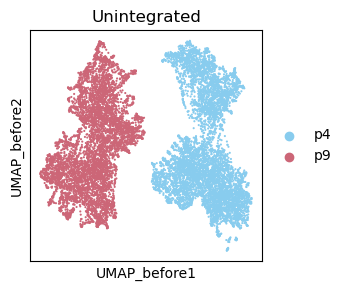

In [23]:
# Plot a UMAP projection across different samples before integration
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata, basis= 'UMAP_before', color='Sample', title='Unintegrated',show=False,palette=cmp_old_biotech)

<Axes: title={'center': 'leiden_before'}, xlabel='UMAP_before1', ylabel='UMAP_before2'>

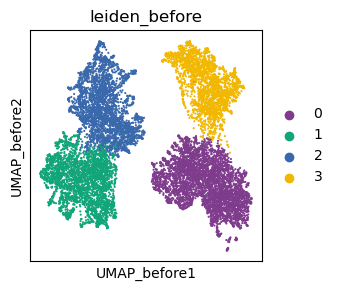

In [24]:
# Generate a plot of the UMAP embedding colored by leiden before integration
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata, basis= 'UMAP_before', color='leiden_before',show=False,palette=cmp_old)

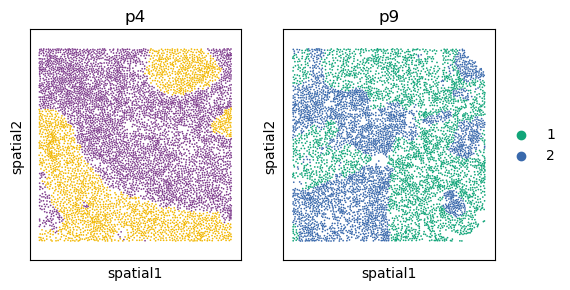

In [25]:
# Display spatial distribution of cells colored by leiden clustering for two samples ('p4' and 'p9')
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
it=0
for temp_tech in ['p4', 'p9']:
    temp_adata = adata[adata.obs['Sample']==temp_tech, ]
    if it == 1:
        ax = sc.pl.embedding(temp_adata, basis="spatial", color="leiden_before",s=6, ax=axs[it],
                        show=False, title=temp_tech)
        ax.axis('equal')
    else:
        ax = sc.pl.embedding(temp_adata, basis="spatial", color="leiden_before",s=6, ax=axs[it], legend_loc=None,
                        show=False, title=temp_tech)
        ax.axis('equal')
    it+=1

## Perform Harmony for spatial data intergration

Harmony is an algorithm for integrating multiple high-dimensional datasets
It can be employed as a reference at https://github.com/slowkow/harmonypy and https://pypi.org/project/harmonypy/

In [26]:
# Import harmonypy package
import harmonypy as hm

In [27]:
# Use STAGATE representation to create 'meta_data' for harmony
data_mat = adata.obsm['STAGATE'].copy()
meta_data = adata.obs.copy()

In [28]:
# Run harmony for STAGATE representation
ho = hm.run_harmony(data_mat, meta_data, ['Sample'])

2023-07-15 06:29:36,293 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


2023-07-15 06:29:38,362 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-07-15 06:29:38,398 - harmonypy - INFO - Iteration 1 of 10
2023-07-15 06:29:40,274 - harmonypy - INFO - Iteration 2 of 10
2023-07-15 06:29:42,312 - harmonypy - INFO - Iteration 3 of 10
2023-07-15 06:29:44,386 - harmonypy - INFO - Iteration 4 of 10
2023-07-15 06:29:46,491 - harmonypy - INFO - Iteration 5 of 10
2023-07-15 06:29:48,491 - harmonypy - INFO - Iteration 6 of 10
2023-07-15 06:29:50,465 - harmonypy - INFO - Iteration 7 of 10
2023-07-15 06:29:52,434 - harmonypy - INFO - Iteration 8 of 10
2023-07-15 06:29:54,389 - harmonypy - INFO - Iteration 9 of 10
2023-07-15 06:29:56,365 - harmonypy - INFO - Iteration 10 of 10
2023-07-15 06:29:58,338 - harmonypy - INFO - Stopped before convergence


In [29]:
# Write the adjusted PCs to a new file.
res = pd.DataFrame(ho.Z_corr)
res.columns = adata.obs_names

In [30]:
# Creates a new AnnData object adata_Harmony using a transpose of the res matrix
adata_Harmony = sc.AnnData(res.T)

In [31]:
adata_Harmony.obsm['spatial'] = pd.DataFrame(adata.obsm['spatial'], index=adata.obs_names).loc[adata_Harmony.obs_names,].values
adata_Harmony.obs['Sample'] = adata.obs.loc[adata_Harmony.obs_names, 'Sample']

In [32]:
# Calculate neighbors, apply UMAP, and perform louvain clustering for the integrated data
sc.pp.neighbors(adata_Harmony)
sc.tl.umap(adata_Harmony)
sc.tl.leiden(adata_Harmony, resolution=0.08)

In [33]:
# Save UMAP and Leiden clustering results after integration
adata.obsm['UMAP_after'] = adata_Harmony.obsm['X_umap']
adata.obs['leiden_after'] = adata_Harmony.obs['leiden']

<Axes: title={'center': 'STAGATE + Harmony'}, xlabel='UMAP_after1', ylabel='UMAP_after2'>

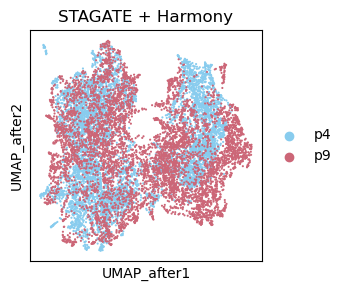

In [34]:
# Plot a UMAP projection across different samples after integration
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata, basis= 'UMAP_after', color='Sample', title='STAGATE + Harmony',show=False, palette=cmp_old_biotech)

<Axes: title={'center': 'leiden_after'}, xlabel='UMAP_after1', ylabel='UMAP_after2'>

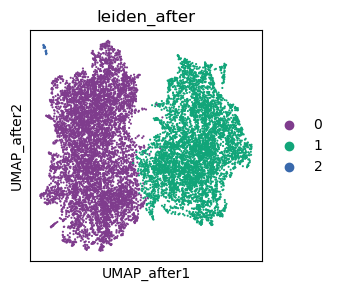

In [35]:
# Generate a plot of the UMAP embedding colored by leiden after integration
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata, basis= 'UMAP_after', color='leiden_after', show=False, palette=cmp_old)

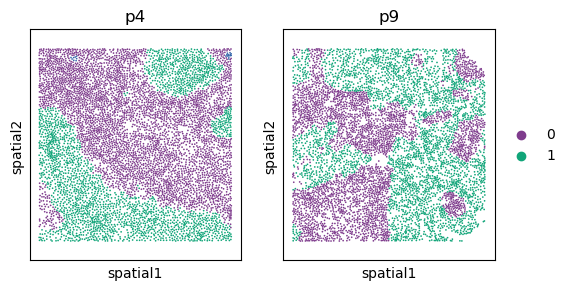

In [36]:
# Display spatial distribution of cells colored by leiden clustering for two samples ('p4' and 'p9') after integration
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
it=0
for temp_tech in ['p4', 'p9']:
    temp_adata = adata[adata.obs['Sample']==temp_tech, ]
    if it == 1:
        ax = sc.pl.embedding(temp_adata, basis="spatial", color="leiden_after",s=6, ax=axs[it],
                        show=False, title=temp_tech)
        ax.axis('equal')
    else:
        ax = sc.pl.embedding(temp_adata, basis="spatial", color="leiden_after",s=6, ax=axs[it], legend_loc=None,
                        show=False, title=temp_tech)
        ax.axis('equal')
    it+=1